# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

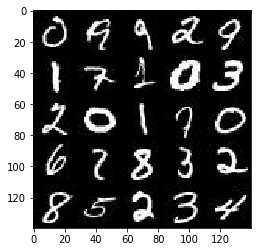

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

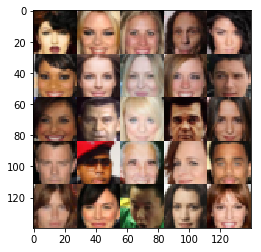

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learningRate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input (Layer 1)
        x1 = tf.layers.conv2d(images, filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(0.1*x1, x1) # Leaky ReLU
        # Now: 14x14x128
        
        # Layer 2
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True) # Batch normalization
        lrelu2 = tf.maximum(0.1*x2, x2) # Leaky ReLU
        # Now: 7x7x256
        
        # Layer 3
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True) # Batch normalization
        
        # Add dropout and then Leaky ReLU
        x3 = tf.nn.dropout(x3, 0.8)
        lrelu3 = tf.maximum(0.1*x3, x3) # Leaky ReLU
        # Now: 4x4x512
        
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1) # Output logits
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # If training, no reuse of weights
    if (is_train):
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        # Fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Process for convolutional layers
        x1 = tf.reshape(x1, (-1, 2,2,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train) # Batch normalization
        lrelu1 = tf.maximum(0.1*x1, x1) # Leaky ReLU
        # Now: 2x2x512
        
        # Conv_transpose_1
        x2 = tf.layers.conv2d_transpose(lrelu1, filters=256, kernel_size=(5,5), strides=(2,2), padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train) # Batch normalization
        lrelu2 = tf.maximum(0.1*x2, x2) # Leaky ReLU
        # Now: 7x7x256
        
        # Conv_transpose_2
        x3 = tf.layers.conv2d_transpose(lrelu2, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train) # Batch normalization
        lrelu3 = tf.maximum(0.1*x3, x3) # Leaky ReLU
        # Now: 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), 
                                            padding='same')
        output = tf.tanh(logits)
        # 28x28x(out_channel_dim)
            
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator real
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # Discriminator fake (takes g_model as input and shares weights with Discriminator real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator Loss real (add label smooting = 0.1)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                        labels = tf.ones_like(d_logits_real)*0.9))
    
    # Discriminator Loss fake
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                        labels = tf.zeros_like(d_logits_fake)))
    
    # Generator Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                   labels = tf.ones_like(d_logits_fake)))
    
    # Total Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize 
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Saver for storing checkpoints
    #saver = tf.train.Saver()
    
    # Image information
    image_width = data_shape[1]
    image_height = data_shape[2]
    if (data_image_mode == "RGB"):
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    # Model inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
                
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
                
    # Optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # For sampling
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            b_steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Normalize to [-1,1]
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print loss info at 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images,
                                            lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, 
                                            lr: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show 5x5=25 images at 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
        # Save          
        #saver.save(sess, './data/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4374... Generator Loss: 0.0662
Epoch 1/2... Discriminator Loss: 2.8620... Generator Loss: 0.1713
Epoch 1/2... Discriminator Loss: 1.9642... Generator Loss: 0.3353
Epoch 1/2... Discriminator Loss: 2.7494... Generator Loss: 0.1670
Epoch 1/2... Discriminator Loss: 4.4142... Generator Loss: 0.0306
Epoch 1/2... Discriminator Loss: 2.4897... Generator Loss: 0.1783
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.8624
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 0.9362


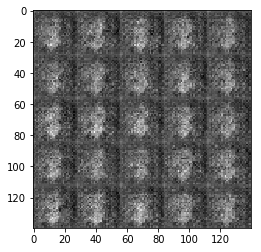

Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.6659
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 1.3818
Epoch 1/2... Discriminator Loss: 1.8008... Generator Loss: 0.3302
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.9891
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.8111


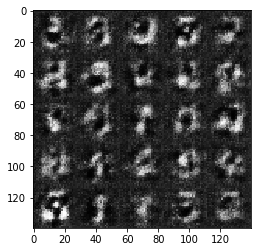

Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.5298... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 2.1085


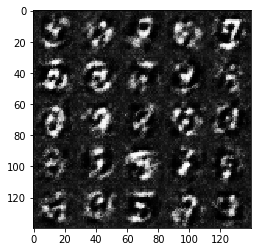

Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 2.3478
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 1.9347
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 2.0393
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 1.8765
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 2.1473
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.7349
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 2.1410
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 2.1435
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.5213


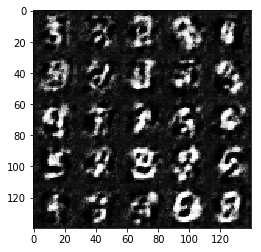

Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 1.9529
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 2.4667
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.5125
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 1.7906
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 2.5651
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 2.1326
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 2.4184
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.8818


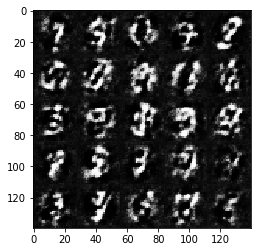

Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.6489
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 2.3585
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 1.3432
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 2.7365
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.6890


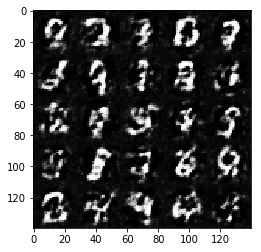

Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.8529
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.9129
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.4658
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.3105


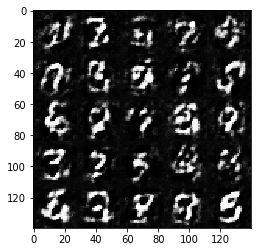

Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.6601
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.7334
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 2.0387
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 2.1504
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.6957


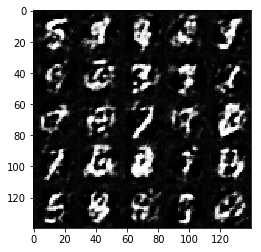

Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 2.0242
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.9390
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.5475
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.8572
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.8645


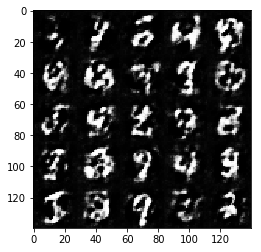

Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 0.9992
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.2814
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.2018
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 2.0922
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 2.0361
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.9902


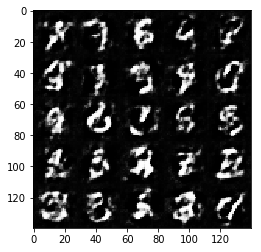

Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.3146
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.5642


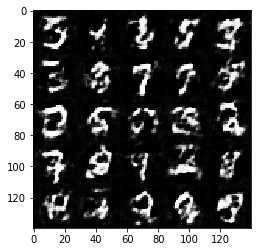

Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.1525


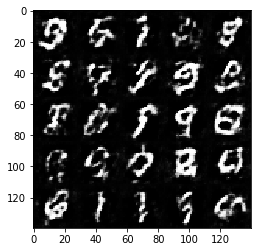

Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.4319
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.6891
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 1.7431
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.4972
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.2893


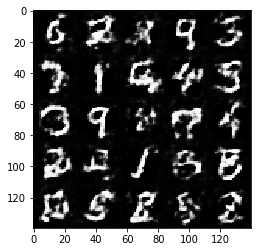

Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.8136
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.4475
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.1325
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.5347
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 2.0427
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.6974


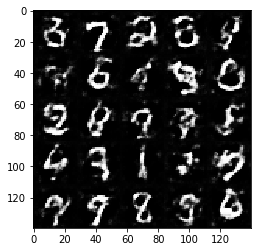

Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 1.6288
Epoch 2/2... Discriminator Loss: 1.1154... Generator Loss: 1.6715
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.6511
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.4593
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.5416
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.9805


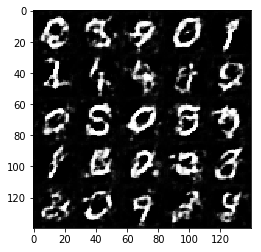

Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.3145
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.6185
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 1.2151


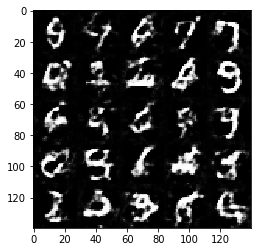

Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 1.7585
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 1.7136
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 1.4387
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.7318
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.2826
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 1.5143
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 1.1722


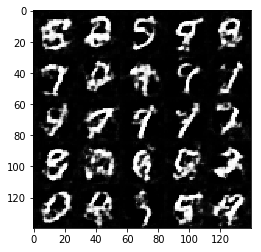

Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.1047
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.8471
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.0757... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 1.2206
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 1.2046


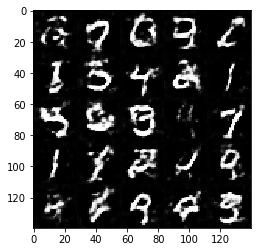

Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 1.6378
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.5246
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.2912


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.7860... Generator Loss: 0.0078
Epoch 1/1... Discriminator Loss: 3.6305... Generator Loss: 0.0630
Epoch 1/1... Discriminator Loss: 3.3019... Generator Loss: 0.0871
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.0264
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.7012
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.5731
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.4129
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.4078
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.8185


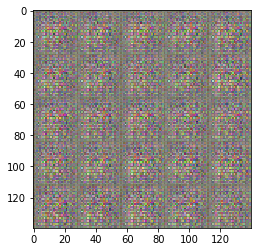

Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 8.5898
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.9873
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 9.2976
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 4.2568
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9359


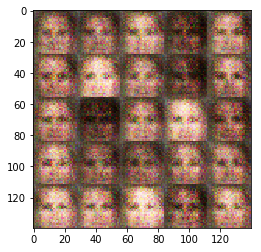

Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 2.6394
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 2.6761
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.7316
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 3.0234
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 3.1608
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 2.9849


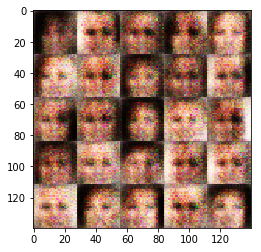

Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 2.5746
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 3.6043
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.7689
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 3.6281
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 3.0285
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 3.2583
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 2.4618
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 2.6128
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 3.0927
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 2.7341


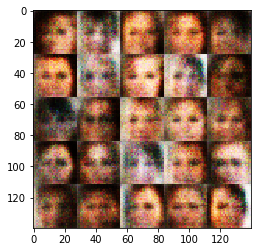

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 2.4245
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.8961
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 2.3447
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 2.3279
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.8359
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 2.3698
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 2.3223


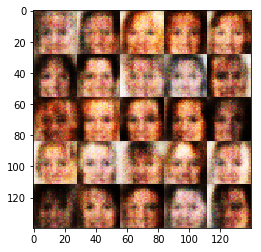

Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.9057
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 2.5436
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 2.5354
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.9317
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 2.0895
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 2.5921
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 2.5545
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 2.4448


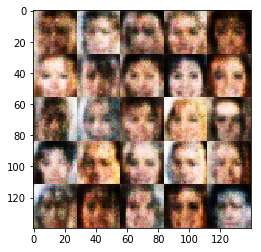

Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 2.4670
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 2.3278
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 2.3584
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 2.4331
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 2.1289
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 2.2219
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 2.5188
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 3.2969
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 3.1587


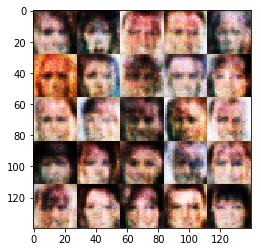

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 2.2939
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 2.4546
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 3.0272
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.7876
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.0651


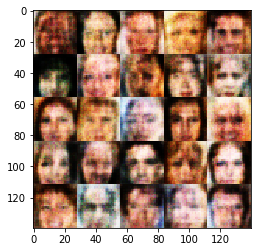

Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.0223
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 3.2724
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 2.6090
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 2.8585
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.9487
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.2652
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.8894


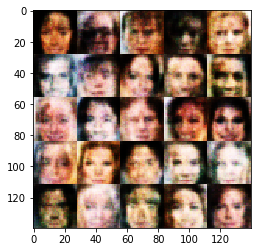

Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 3.3335
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.9193
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 3.6395
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.0963


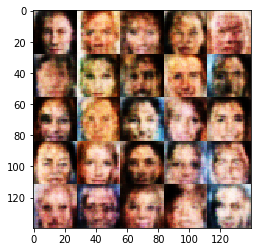

Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 4.8264
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 4.0652
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.5329... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 2.8325
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 4.3289


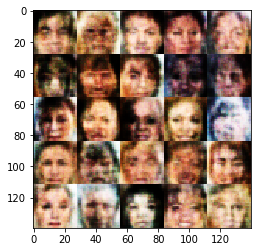

Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 4.9323
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 4.8003
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 4.8101
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 3.6750
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 4.4470
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.4048
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.3650


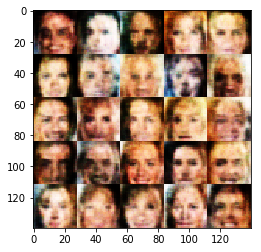

Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.0472
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.1854
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 3.1141
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.1702


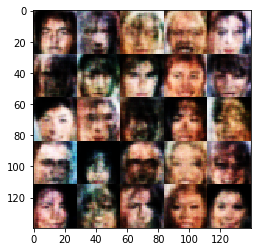

Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 4.9436
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 3.7080


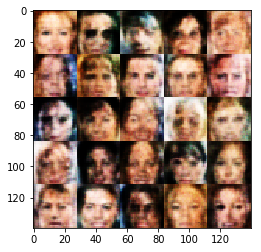

Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 5.2248
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.5436
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.6241
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 1.8546


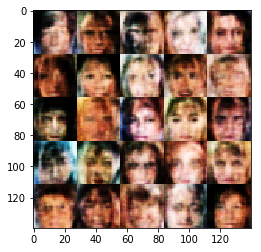

Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 6.2157
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 5.9368
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 4.6009
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 5.6662
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 3.7587
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 6.9351
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 6.6897
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.6223
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 6.6381


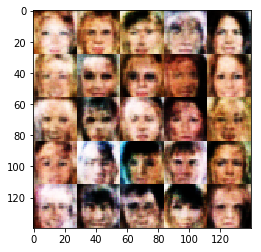

Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 4.8628
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 8.2146
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 7.6149
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.1827
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.5120
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 1.9808
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.5508


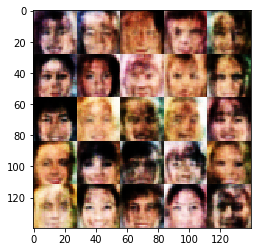

Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.4708
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 4.7441
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 3.7171
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 5.7330
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 4.5108
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 6.2704
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 6.2265
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 7.3495


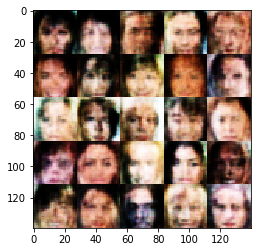

Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 6.7727
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 7.2907
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 6.4980
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 5.2617
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.8421
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 6.9485
Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 8.1383
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 5.2150
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 7.4733
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 8.0256


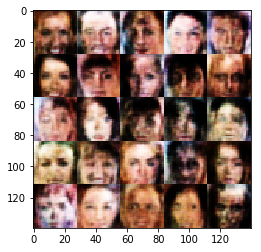

Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 5.8012
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 7.2866
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 7.9123
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 8.6259
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 9.1155
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 5.1153
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 3.3249... Generator Loss: 0.0939
Epoch 1/1... Discriminator Loss: 1.7630... Generator Loss: 0.3243


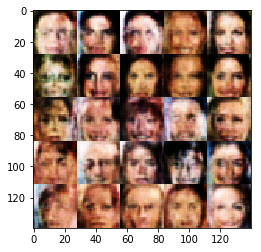

Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 6.6699
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.3664
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 5.5117
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 7.0010
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 5.4580


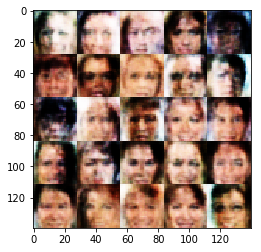

Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 7.2273
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 6.8276
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 3.4497
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 8.6758
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 5.1357
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 6.1879
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.9707
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 4.4638
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 6.8030


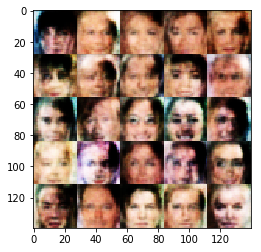

Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.4256
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 7.3776
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 5.0422
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 4.6442
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 5.4833
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.9595
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 6.2100
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 6.4397
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.5207
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.8494


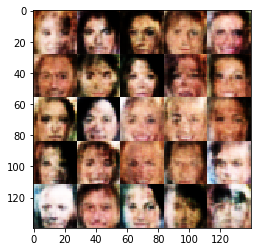

Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.3565
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.3204
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 2.8576
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 6.4963
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 4.7598
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 4.8953
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 4.0260
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.6899
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 5.3398


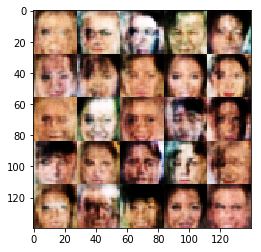

Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.9002
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 2.5136
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 4.1511
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.0090
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 5.9128
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 3.7385
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 4.6253
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 4.2492
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 5.4052


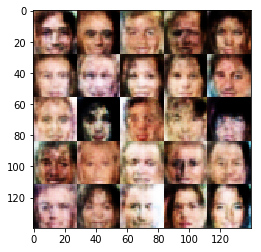

Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 6.1380
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 5.6213
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 7.1594
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.7743
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.8464
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.7537
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 5.9864
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 5.2690


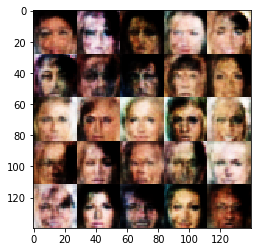

Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 4.7760
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 3.6133
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 4.6363
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 5.0355
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 5.7824
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.8548


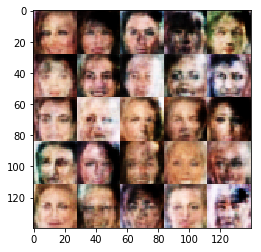

Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 6.1856
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 4.3344
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 3.6916
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 4.1255
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 4.1637
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 1.7901
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 4.2250


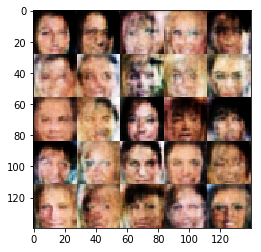

Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.7271
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.9351
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.2347
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.4235
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 3.4014
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 5.4202


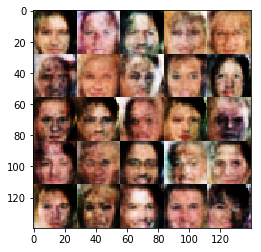

Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.3123
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 3.8217
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 2.7789
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.9512
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.3798
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.4011
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.7285
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6306


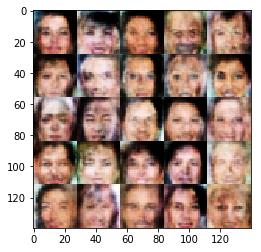

Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.5967
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.2162
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 3.3233
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 3.6459
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 4.5480
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 4.1460
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.7883
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.3944
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.3726


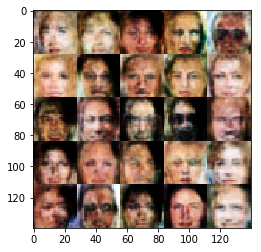

Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 3.4071
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.3839
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.7757
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 2.5698
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.7836
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.6277


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.